# Notebook for 311 request analysis

- Initial data report
- Compute completion time
- Estimate completion times using Machine Learning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from datetime import datetime
from datetime import timedelta
from IPython.display import display
import folium
from folium.plugins import HeatMap
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore")

See files in folder

In [2]:
!ls

data analysis.ipynb
data_inspect.ipynb
debug.log
haverhill_analysis.ipynb
haverhill-activity.csv
haverhill-request.csv
marker_map.html
README.md


In [3]:
# Read data for activity
activity = pd.read_csv("haverhill-activity.csv")
activity.head(5)

,Activity ID,Activity Type,Activity Code,Activity Date,Request ID
0,9821,Created,9,2017-01-03 13:11:00,5130
1,9822,Activity entered,7,2017-01-03 13:11:00,5130
2,9823,Service Request Type changed,5,2017-01-03 13:20:00,5130
3,9824,Routed,1,2017-01-03 13:20:00,5130
4,9825,Service Request Type changed,5,2017-01-03 13:21:00,5130


In [4]:
# Read data for request
request = pd.read_csv("haverhill-request.csv", encoding = 'unicode_escape')
request.head(5)

,Request ID,Create Date,Master Request,Has Links,Status,Status Code,Last Action,Last Change,Close Date,Work Order Created,...,Cross Street ID,Cross Street,District ID,District,Escalations,Priority,Longitude,Latitude,Origin ID,Origin
0,5130,2017-01-03 13:11:00,0,False,Closed,1,2017-01-03 14:05:00,2017-01-03 14:05:00,2017-01-03 14:05:00,False,...,0,NaN,1,Mt Washington,0,2,-71.105902,42.767552,1,Call Center
1,5131,2017-01-03 13:29:00,0,False,Closed,1,2017-01-03 13:29:00,2017-01-03 13:29:00,2017-01-03 13:29:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center
2,5132,2017-01-03 13:33:00,0,False,Closed,1,2017-01-03 13:33:00,2017-01-03 13:33:00,2017-01-03 13:33:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center
3,5133,2017-01-03 13:47:00,0,False,Closed,1,2017-01-03 13:47:00,2017-01-03 13:47:00,2017-01-03 13:47:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center
4,5134,2017-01-03 13:47:00,0,False,Closed,1,2017-01-03 13:47:00,2017-01-03 13:47:00,2017-01-03 13:47:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center
5,5135,2017-01-03 13:53:00,0,False,Closed,1,2017-01-03 13:53:00,2017-01-03 13:53:00,2017-01-03 13:53:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center
6,5136,2017-01-03 13:55:00,0,False,Closed,1,2017-01-03 13:55:00,2017-01-03 13:55:00,2017-01-03 13:55:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center
7,5137,2017-01-03 13:57:00,0,False,Closed,1,2017-01-03 13:57:00,2017-01-03 13:57:00,2017-01-03 13:57:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center
8,5138,2017-01-03 13:57:00,0,False,Closed,1,2017-01-03 13:57:00,2017-01-03 13:57:00,2017-01-03 13:57:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center
9,5139,2017-01-03 14:03:00,0,False,Closed,1,2017-01-03 14:03:00,2017-01-03 14:03:00,2017-01-03 14:03:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center


**Plot Status and Origin of requests** 

In [5]:
request['Status'].unique()
request['Origin'].unique()

array(['Call Center', 'Control Panel', 'Website', 'Report2Gov iOS',
       'Report2Gov Android', 'Text Message', 'Report2Gov Website'],
      dtype=object)

In [6]:
len(request)

70060

<Figure size 432x288 with 0 Axes>

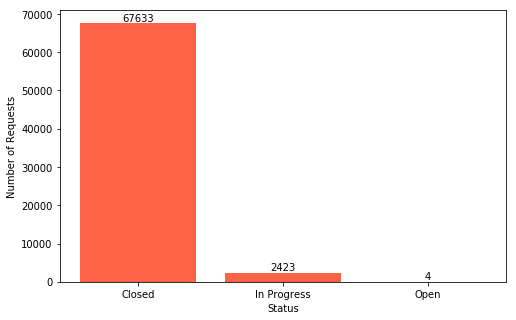

In [7]:
plt.figure()
fig, ax = plt.subplots(figsize = (8,5))
labels = list(request['Status'].unique())
percentages = list(request['Status'].value_counts())
bars = plt.bar(labels, percentages, color='tomato')
plt.xlabel('Status')
plt.ylabel('Number of Requests')
for i, val in enumerate(bars):
    height = val.get_height()
    plt.text(val.get_x() + val.get_width()/2.0, height, percentages[i], ha='center', va='bottom')

In [8]:
request['Status'].value_counts()

Closed         67633
In Progress     2423
Open               4
Name: Status, dtype: int64

<Figure size 432x288 with 0 Axes>

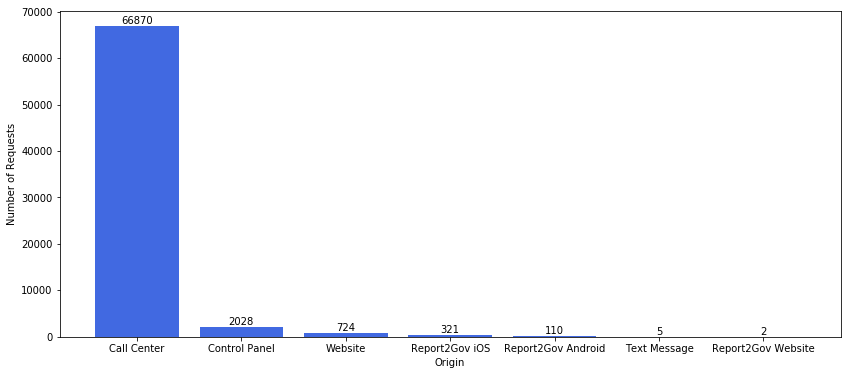

In [9]:
plt.figure()
fig, ax = plt.subplots(figsize = (14,6))
labels = list(request['Origin'].unique())
percentages = list(request['Origin'].value_counts())
bars = plt.bar(labels, percentages, color='royalblue')
plt.xlabel('Origin')
plt.ylabel('Number of Requests')
for i, val in enumerate(bars):
    height = val.get_height()
    plt.text(val.get_x() + val.get_width()/2.0, height, percentages[i], ha='center', va='bottom')

In [10]:
request['Origin'].value_counts()

Call Center           66870
Website                2028
Control Panel           724
Report2Gov iOS          321
Report2Gov Android      110
Text Message              5
Report2Gov Website        2
Name: Origin, dtype: int64

# Latitude Longitude

Text(0,0.5,'Latitude')

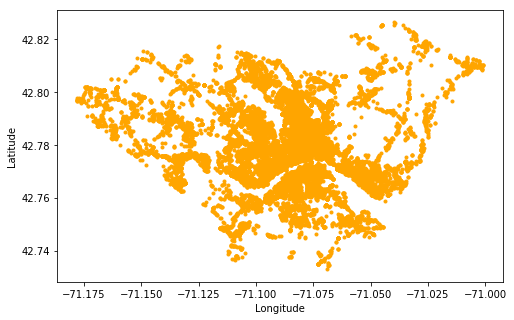

In [11]:
plt.figure(figsize = (8,5))
lat_long = request[['Longitude', 'Latitude', 'Request Type ID']]
lat_long = lat_long.replace(0, np.nan)
lat_long = lat_long.dropna()
lat_long.head(10)
plt.plot(lat_long['Longitude'], lat_long['Latitude'], '.', color='orange')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [12]:
print(set(lat_long['Request Type ID']))
len(set(lat_long['Request Type ID']))

{1027, 16909, 13839, 1049, 1050, 12852, 54326, 11834, 1089, 1094, 1096, 1097, 2138, 1121, 64611, 64617, 64626, 62583, 5771, 71823, 47760, 54574, 71825, 56470, 37526, 71842, 32443, 32444, 10429, 13503, 9411, 71877, 47843, 5871, 55539, 40693, 251, 252, 253, 254, 7425, 7426, 259, 258, 261, 262, 263, 264, 267, 268, 269, 270, 273, 274, 277, 280, 282, 8476, 285, 284, 287, 289, 38689, 291, 8995, 293, 294, 8997, 296, 292, 8998, 297, 300, 8996, 302, 301, 299, 304, 306, 307, 308, 309, 310, 311, 312, 314, 315, 317, 318, 319, 320, 321, 322, 51008, 325, 326, 328, 330, 331, 333, 334, 336, 1873, 338, 339, 341, 342, 343, 344, 345, 346, 3928, 348, 349, 350, 351, 352, 353, 5988, 356, 357, 359, 361, 362, 363, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 17279, 384, 2433, 386, 383, 9604, 901, 902, 391, 389, 390, 923, 13216, 933, 37286, 37291, 61365, 1980, 4031, 1984, 974, 975, 1507, 11242, 303, 1015}


161

In [13]:
len(lat_long)

18080

In [14]:
marker_map = folium.Map(location=[42.7762, -71.0773], control_scale=True, zoom_start=10)
test = lat_long.sample(1000)
test = np.array(test)
test[:5]
for i in range(len(test)):
    folium.Marker([test[i,1], test[i,0]], popup = "$"+str(test[i,2])).add_to(marker_map) 
marker_map.save('marker_map.html')

In [15]:
# display(marker_map)

# Dates

In [16]:
req = request[request.Status == 'Closed']
print(len(req))

67633


In [17]:
create = req['Create Date']
len(create)

67633

In [18]:
close = req['Close Date']
len(close)

67633

In [19]:
req.head()

,Request ID,Create Date,Master Request,Has Links,Status,Status Code,Last Action,Last Change,Close Date,Work Order Created,...,Cross Street ID,Cross Street,District ID,District,Escalations,Priority,Longitude,Latitude,Origin ID,Origin
0,5130,2017-01-03 13:11:00,0,False,Closed,1,2017-01-03 14:05:00,2017-01-03 14:05:00,2017-01-03 14:05:00,False,...,0,NaN,1,Mt Washington,0,2,-71.105902,42.767552,1,Call Center
1,5131,2017-01-03 13:29:00,0,False,Closed,1,2017-01-03 13:29:00,2017-01-03 13:29:00,2017-01-03 13:29:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center
2,5132,2017-01-03 13:33:00,0,False,Closed,1,2017-01-03 13:33:00,2017-01-03 13:33:00,2017-01-03 13:33:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center
3,5133,2017-01-03 13:47:00,0,False,Closed,1,2017-01-03 13:47:00,2017-01-03 13:47:00,2017-01-03 13:47:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center
4,5134,2017-01-03 13:47:00,0,False,Closed,1,2017-01-03 13:47:00,2017-01-03 13:47:00,2017-01-03 13:47:00,False,...,0,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center


In [20]:
import time
def __datetime(date):
    '''Compute date is standard format'''
    return datetime.strptime(date, "%Y-%m-%d %H:%M:%S")

In [21]:
time_taken = list()
for idx, row in req.iterrows():
    try:
        start = __datetime(create[idx])
        end = __datetime(close[idx])
        time_taken.append(str(end-start))
    except:
        req.drop(idx, inplace=True)
        pass

In [22]:
print(len(time_taken),len(req))

67633 67633


In [23]:
time_taken = list(time_taken)
len(time_taken)

67633

In [24]:
req['completion time'] = time_taken

In [25]:
req.head(5)

,Request ID,Create Date,Master Request,Has Links,Status,Status Code,Last Action,Last Change,Close Date,Work Order Created,...,Cross Street,District ID,District,Escalations,Priority,Longitude,Latitude,Origin ID,Origin,completion time
0,5130,2017-01-03 13:11:00,0,False,Closed,1,2017-01-03 14:05:00,2017-01-03 14:05:00,2017-01-03 14:05:00,False,...,NaN,1,Mt Washington,0,2,-71.105902,42.767552,1,Call Center,0:54:00
1,5131,2017-01-03 13:29:00,0,False,Closed,1,2017-01-03 13:29:00,2017-01-03 13:29:00,2017-01-03 13:29:00,False,...,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00
2,5132,2017-01-03 13:33:00,0,False,Closed,1,2017-01-03 13:33:00,2017-01-03 13:33:00,2017-01-03 13:33:00,False,...,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00
3,5133,2017-01-03 13:47:00,0,False,Closed,1,2017-01-03 13:47:00,2017-01-03 13:47:00,2017-01-03 13:47:00,False,...,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00
4,5134,2017-01-03 13:47:00,0,False,Closed,1,2017-01-03 13:47:00,2017-01-03 13:47:00,2017-01-03 13:47:00,False,...,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00
5,5135,2017-01-03 13:53:00,0,False,Closed,1,2017-01-03 13:53:00,2017-01-03 13:53:00,2017-01-03 13:53:00,False,...,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00
6,5136,2017-01-03 13:55:00,0,False,Closed,1,2017-01-03 13:55:00,2017-01-03 13:55:00,2017-01-03 13:55:00,False,...,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00
7,5137,2017-01-03 13:57:00,0,False,Closed,1,2017-01-03 13:57:00,2017-01-03 13:57:00,2017-01-03 13:57:00,False,...,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00
8,5138,2017-01-03 13:57:00,0,False,Closed,1,2017-01-03 13:57:00,2017-01-03 13:57:00,2017-01-03 13:57:00,False,...,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00
9,5139,2017-01-03 14:03:00,0,False,Closed,1,2017-01-03 14:03:00,2017-01-03 14:03:00,2017-01-03 14:03:00,False,...,NaN,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00


# Completion time (sec)

In [30]:
def sec(timesec):
    '''Convert date from standard format to seconds'''
    timesec = timesec.replace(' days, ', ':')
    timesec = timesec.replace(' day, ', ':')
    timesec = timesec.split(':')
    if len(timesec) >= 4:
        res = int(timesec[0])*86400 + int(timesec[1])*3600 + int(timesec[2])*60 + int(timesec[3])
    else:
        res = int(timesec[0])*3600 + int(timesec[1])*60 + int(timesec[2])
    return res

In [31]:
timesec = req['completion time']
time_sec = list()
for idx, row in req.iterrows():
    res = sec(timesec[idx])
    time_sec.append(res)

In [34]:
req['completion time(sec)'] = time_sec

In [35]:
req.head(5)

,Request ID,Create Date,Master Request,Has Links,Status,Status Code,Last Action,Last Change,Close Date,Work Order Created,...,District ID,District,Escalations,Priority,Longitude,Latitude,Origin ID,Origin,completion time,completion time(sec)
0,5130,2017-01-03 13:11:00,0,False,Closed,1,2017-01-03 14:05:00,2017-01-03 14:05:00,2017-01-03 14:05:00,False,...,1,Mt Washington,0,2,-71.105902,42.767552,1,Call Center,0:54:00,3240
1,5131,2017-01-03 13:29:00,0,False,Closed,1,2017-01-03 13:29:00,2017-01-03 13:29:00,2017-01-03 13:29:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0
2,5132,2017-01-03 13:33:00,0,False,Closed,1,2017-01-03 13:33:00,2017-01-03 13:33:00,2017-01-03 13:33:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0
3,5133,2017-01-03 13:47:00,0,False,Closed,1,2017-01-03 13:47:00,2017-01-03 13:47:00,2017-01-03 13:47:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0
4,5134,2017-01-03 13:47:00,0,False,Closed,1,2017-01-03 13:47:00,2017-01-03 13:47:00,2017-01-03 13:47:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0
5,5135,2017-01-03 13:53:00,0,False,Closed,1,2017-01-03 13:53:00,2017-01-03 13:53:00,2017-01-03 13:53:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0
6,5136,2017-01-03 13:55:00,0,False,Closed,1,2017-01-03 13:55:00,2017-01-03 13:55:00,2017-01-03 13:55:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0
7,5137,2017-01-03 13:57:00,0,False,Closed,1,2017-01-03 13:57:00,2017-01-03 13:57:00,2017-01-03 13:57:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0
8,5138,2017-01-03 13:57:00,0,False,Closed,1,2017-01-03 13:57:00,2017-01-03 13:57:00,2017-01-03 13:57:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0
9,5139,2017-01-03 14:03:00,0,False,Closed,1,2017-01-03 14:03:00,2017-01-03 14:03:00,2017-01-03 14:03:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0


# Department

For analysis of Department data we used all data points and their completion times. 0 time values are dropped only to perform Machine learning.

In [36]:
dept = request['Department']
dept.head(5)

0            Highway
1    311 Call Center
2    311 Call Center
3    311 Call Center
4    311 Call Center
Name: Department, dtype: object

In [37]:
dept.value_counts()

311 Call Center                25014
Highway                        15100
Stormwater/Sewer                 371
Inspectional Services            313
Water                            171
Animal control                   168
Fire & Police                    109
Police                           104
Water/Wastewater Department       81
Fire                              34
Mayor                             22
Water Billing                     10
Treasurer                          7
Planning                           6
City Clerk                         5
Assessing                          2
Name: Department, dtype: int64

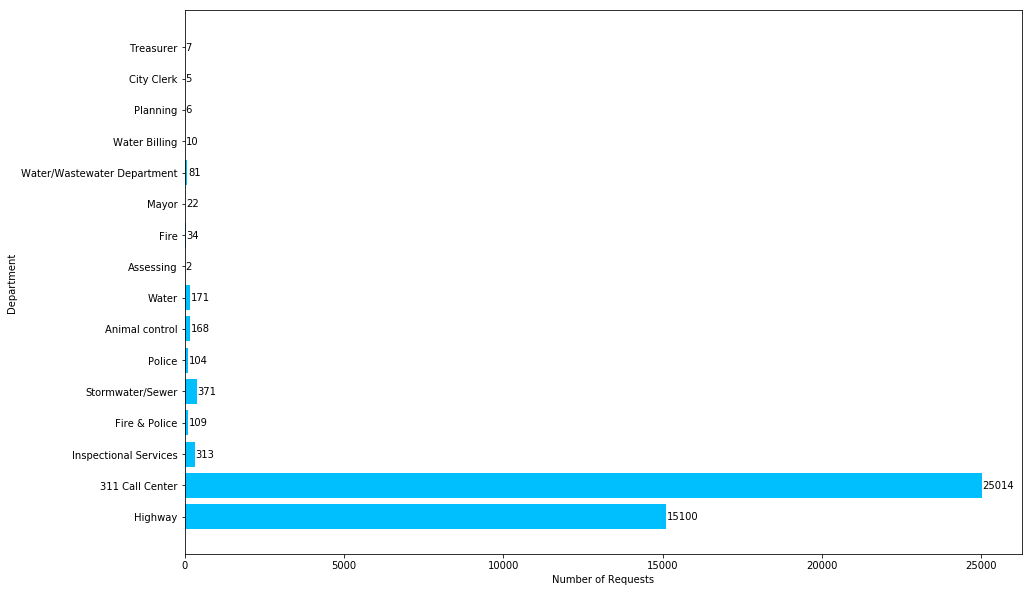

In [38]:
fig, ax = plt.subplots(figsize = (15,10))
labels = list(request['Department'].unique())
labels = [x for x in labels if x == x]
percentages = [15100, 25014, 313, 109, 371, 104, 168, 171, 2, 34, 22, 81,10, 6, 5, 7]
bars = plt.barh(labels, percentages, color=['deepskyblue'])
plt.ylabel('Department')
plt.xlabel('Number of Requests')
for i, val in enumerate(percentages):
#     height = val.get_height()
    plt.text(val+20, i, percentages[i], va='center')

In [42]:
req.head(5)

,Request ID,Create Date,Master Request,Has Links,Status,Status Code,Last Action,Last Change,Close Date,Work Order Created,...,District ID,District,Escalations,Priority,Longitude,Latitude,Origin ID,Origin,completion time,completion time(sec)
0,5130,2017-01-03 13:11:00,0,False,Closed,1,2017-01-03 14:05:00,2017-01-03 14:05:00,2017-01-03 14:05:00,False,...,1,Mt Washington,0,2,-71.105902,42.767552,1,Call Center,0:54:00,3240
1,5131,2017-01-03 13:29:00,0,False,Closed,1,2017-01-03 13:29:00,2017-01-03 13:29:00,2017-01-03 13:29:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0
2,5132,2017-01-03 13:33:00,0,False,Closed,1,2017-01-03 13:33:00,2017-01-03 13:33:00,2017-01-03 13:33:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0
3,5133,2017-01-03 13:47:00,0,False,Closed,1,2017-01-03 13:47:00,2017-01-03 13:47:00,2017-01-03 13:47:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0
4,5134,2017-01-03 13:47:00,0,False,Closed,1,2017-01-03 13:47:00,2017-01-03 13:47:00,2017-01-03 13:47:00,False,...,0,NaN,0,2,0.000000,0.000000,1,Call Center,0:00:00,0


In [43]:
dept = req[['Department', 'Request Type', 'completion time(sec)']]
dept.head(10)

,Department,Request Type,completion time(sec)
0,Highway,Traffic/Street Lights - Street Light Repair - ...,3240
1,311 Call Center,A - Information Other,0
2,311 Call Center,A - Information Other,0
3,311 Call Center,A - Information Other,0
4,311 Call Center,A - Information Other,0
5,311 Call Center,A - Transfer Other,0
6,311 Call Center,A - Transfer Other,0
7,311 Call Center,A - Information Other,0
8,311 Call Center,A - Transfer Other,0
9,311 Call Center,A - Information Other,0


In [44]:
dept = dept.replace(0, np.nan)
dept = dept.dropna()

In [45]:
dept.head(10)

,Department,Request Type,completion time(sec)
0,Highway,Traffic/Street Lights - Street Light Repair - ...,3240.0
10,Highway,Snow Removal Issues - Sanding Request,13800.0
12,Highway,Traffic/Street Lights - Street Light Repair - ...,14780580.0
15,Highway,Highway - Pothole,1215960.0
17,Inspectional Services,Trash - Enforcement,11100.0
35,Highway,Traffic/Street Lights - Street Light Repair - ...,7020.0
37,Inspectional Services,Poor Property Maintenance,4231380.0
43,Highway,Traffic/Street Lights - Street Light Repair - ...,5880.0
44,Highway,Snow Removal Issues - Replow Request,5820.0
81,Highway,TRASH - Missed Pick Up,80940.0


In [46]:
# import Machine Learning libraries
from sklearn.svm import LinearSVR
from sklearn.preprocessing import LabelEncoder

def rmse(predictions, targets):
    '''Define Root mean squared error and as metric to perform error analysis'''
    return np.sqrt(((predictions - targets) ** 2).mean())

#### Department: Highway

In [47]:
dept_highway = dept.loc[dept.Department == 'Highway']
len(dept_highway)

11953

In [48]:
y = np.array(dept_highway['completion time(sec)'])
X = np.array(dept_highway['Request Type'])

In [49]:
dept_highway['Request Type'].value_counts()

Highway - Pothole                              2620
Snow Removal Issues - Sanding Request          1047
Snow Removal Issues - Replow Request            644
Tree Issues - City Owned Tree Issue             565
Traffic/Street Lights - Street Light Repair     515
                                               ... 
Trash - Bag Request                               2
Recycling Drop-off Center                         2
New Construction Request                          2
Construction Issues - Street Closings             2
Trash Cart Management                             1
Name: Request Type, Length: 63, dtype: int64

In [50]:
X = X.reshape(-1,1)
y = y.reshape(-1,1)

In [51]:
X = X.astype('str')

In [52]:
labelenc = LabelEncoder() # Used to convert labels from string to categorical
X = labelenc.fit_transform(X)
X = X.reshape(-1,1)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [54]:
svm = LinearSVR(C=3000, tol=3000)
svm.fit(X_train, y_train)

LinearSVR(C=3000, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=3000, verbose=0)

In [55]:
preds_train = svm.predict(X_train)
err_train = rmse(preds_train, y_train)
print(err_train)

8512283.684204804


In [56]:
preds_test = svm.predict(X_test)
err_test = rmse(preds_test, y_test)
print(err_test)

7774370.515679615


In [57]:
preds = svm.predict(X)

In [58]:
preds = list(preds)
for idx, row in tqdm(enumerate(preds), total=len(preds)):
    preds[idx] = str(timedelta(seconds = preds[idx]))

In [59]:
dept_highway['Predictions'] = preds
dept_highway.head()

,Department,Request Type,completion time(sec),Predictions
0,Highway,Traffic/Street Lights - Street Light Repair - ...,3240.0,"28 days, 16:54:06.573598"
10,Highway,Snow Removal Issues - Sanding Request,13800.0,"24 days, 17:13:15.970637"
12,Highway,Traffic/Street Lights - Street Light Repair - ...,14780580.0,"28 days, 16:54:06.573598"
15,Highway,Highway - Pothole,1215960.0,"16 days, 9:09:41.073535"
35,Highway,Traffic/Street Lights - Street Light Repair - ...,7020.0,"28 days, 16:54:06.573598"


In [60]:
dept_highway['Request Type'].unique()

array(['Traffic/Street Lights - Street Light Repair - National Grid-Owned',
       'Snow Removal Issues - Sanding Request', 'Highway - Pothole',
       'Snow Removal Issues - Replow Request', 'TRASH - Missed Pick Up',
       'Tree Issues - Tree Pruning/Trimming', 'Trash - Illegal Dumping',
       'Recycling Drop-off Center', 'Highway - Street Paving Request',
       'Tree Issues - Tree Removal',
       'Tree Issues - City Owned Tree Issue',
       'RECYCLING - Missed Pick Up', 'Highway - Street Cleaning/Sweeping',
       'Snow Removal Issues - Street Unplowed', 'Litter Problems',
       'Street Sign Issues - Street Signs Missing/Damaged',
       'Snow Removal Issues - Private Property Damage',
       'Trash - Barrel Overflow',
       'Street Sign Issues - Stop Sign Missing/Damaged',
       'Highway - Crosswalk', 'XMAS TREE - Missed pick up',
       'Toter Issues', 'Snow Removal Issues - Ice buildup',
       'Highway - Bee Issue', 'Highway - Catch Basin Repair',
       'Construction Iss

In [61]:
dept_highway['Predictions'].unique()

array(['28 days, 16:54:06.573598', '24 days, 17:13:15.970637',
       '16 days, 9:09:41.073535', '24 days, 8:31:22.279458',
       '27 days, 14:48:25.500063', '31 days, 14:29:16.103025',
       '29 days, 18:59:47.647133', '22 days, 21:43:47.514745',
       '18 days, 13:21:03.220605', '31 days, 23:11:09.794203',
       '30 days, 12:23:35.029490', '22 days, 13:01:53.823567',
       '17 days, 19:57:15.838248', '25 days, 19:18:57.044172',
       '20 days, 8:50:31.676497', '27 days, 6:06:31.808885',
       '23 days, 23:49:28.588280', '29 days, 10:17:53.955955',
       '26 days, 21:24:38.117707', '13 days, 20:16:25.235287',
       '33 days, 9:58:44.558917', '27 days, 23:30:19.191242',
       '23 days, 6:25:41.205923', '12 days, 18:10:44.161752',
       '13 days, 2:52:37.852930', '10 days, 22:41:15.705860',
       '21 days, 2:14:19.058853', '16 days, 17:51:34.764713',
       '25 days, 1:55:09.661815', '25 days, 10:37:03.352993',
       '21 days, 10:56:12.750032', '31 days, 5:47:22.411847',
  

#### Department: Inspectional Services

In [62]:
dept_is = dept.loc[dept.Department == 'Inspectional Services']
len(dept_is)

205

In [63]:
y = np.array(dept_is['completion time(sec)'])
X = np.array(dept_is['Request Type'])

In [64]:
labelenc = LabelEncoder()
X = labelenc.fit_transform(X)
X = X.reshape(-1,1)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [66]:
svm = LinearSVR(C=12500, tol=3000)
svm.fit(X_train, y_train)

LinearSVR(C=12500, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=3000, verbose=0)

In [67]:
preds_train = svm.predict(X_train)
err_train = rmse(preds_train, y_train)
print(err_train)

12746897.186183529


In [68]:
preds_test = svm.predict(X_test)
err_test = rmse(preds_test, y_test)
print(err_test)

14263761.829813309


In [69]:
preds = svm.predict(X)

In [70]:
preds = list(preds)
for idx, row in tqdm(enumerate(preds), total=len(preds)):
    preds[idx] = str(timedelta(seconds = preds[idx]))

In [71]:
dept_is['Predictions'] = preds
# dept_is.tail(50)

In [72]:
dept_is['Request Type'].unique()

array(['Trash - Enforcement', 'Poor Property Maintenance',
       'Traffic/Street Lights - Street light/pole request',
       'Graffiti - Private Property',
       'Traffic/Street Lights - Street Light Request - National Grid-Owned',
       'Accumulation of Litter/Garbage', 'Vacant Building',
       'Health & Inspections',
       'Traffic/Street Lights - Street Light Request',
       'Excessive Noise/Disturbances', 'Overgrown Grass/Weeds',
       'Odor Issues', 'Odor Complaint', 'Pool Issues',
       'Illegal Work/No Visible Building Permit', 'Chickens',
       'Unsafe Structures', 'Residence', 'Other: Inspection Requested'],
      dtype=object)

In [73]:
dept_is['Predictions'].unique()

array(['13 days, 18:26:57.737854', '10 days, 13:02:23.680415',
       '13 days, 2:58:02.926366', '5 days, 9:11:05.188512',
       '12 days, 11:29:08.114878', '3 days, 10:44:20.754049',
       '15 days, 1:24:47.360830', '6 days, 0:40:00',
       '11 days, 20:00:13.303390', '4 days, 17:42:10.377024',
       '9 days, 6:04:34.057439', '7 days, 23:06:44.434463',
       '7 days, 7:37:49.622976', '9 days, 21:33:28.868927',
       '6 days, 16:08:54.811488', '4 days, 2:13:15.565537',
       '14 days, 9:55:52.549342', '11 days, 4:31:18.491903',
       '8 days, 14:35:39.245951'], dtype=object)

#### Department: 311 Call Center

In [74]:
dept_311 = dept.loc[dept.Department == '311 Call Center']
len(dept_311)

396

In [75]:
y = np.array(dept_311['completion time(sec)'])
X = np.array(dept_311['Request Type'])

In [76]:
labelenc = LabelEncoder()
X = labelenc.fit_transform(X)
X = X.reshape(-1,1)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [78]:
svm = LinearSVR(C=1000)
svm.fit(X_train, y_train)

LinearSVR(C=1000, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [79]:
preds_train = svm.predict(X_train)
err_train = rmse(preds_train, y_train)
print(err_train)

7260333.478064058


In [80]:
preds_test = svm.predict(X_test)
err_test = rmse(preds_test, y_test)
print(err_test)

6237766.153484755


In [81]:
preds = svm.predict(X)

In [82]:
preds = list(preds)
for idx, row in tqdm(enumerate(preds), total=len(preds)):
    preds[idx] = str(timedelta(seconds = preds[idx]))

In [83]:
dept_311['Predictions'] = preds
dept_311.head()

,Department,Request Type,completion time(sec),Predictions
156,311 Call Center,A - Information Other,5580.0,1:46:00
161,311 Call Center,A - Information Other,3900.0,1:46:00
415,311 Call Center,A - Transfer Other,60.0,8:09:20
569,311 Call Center,A - Information Other,766020.0,1:46:00
700,311 Call Center,A - Transfer Other,60.0,8:09:20


In [84]:
dept_311['Request Type'].unique()

array(['A - Information Other', 'A - Transfer Other',
       'LAZ - Downtown Parking Issue', 'Parking Meter Malfunction',
       'Handicapped Parking Sign Request', 'Train Idling Compaint',
       'Resident Feedback'], dtype=object)

In [85]:
dept_311['Predictions'].unique()

array(['1:46:00', '8:09:20', '20:56:00', '1 day, 3:19:20', '14:32:40',
       '1 day, 16:06:00', '1 day, 9:42:40'], dtype=object)

#### Department: Fire and Police

In [86]:
dept_fp = dept.loc[dept.Department == 'Fire & Police']
len(dept_fp)

94

In [87]:
y = np.array(dept_fp['completion time(sec)'])
X = np.array(dept_fp['Request Type'])

In [88]:
labelenc = LabelEncoder()
X = labelenc.fit_transform(X)
X = X.reshape(-1,1)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [90]:
svm = LinearSVR(C=100000, tol=100000)
svm.fit(X_train, y_train)

LinearSVR(C=100000, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=100000, verbose=0)

In [91]:
preds_train = svm.predict(X_train)
err_train = rmse(preds_train, y_train)
print(err_train)

1691032.0765142215


In [92]:
preds_test = svm.predict(X_test)
err_test = rmse(preds_test, y_test)
print(err_test)

1320945.8099483112


In [93]:
preds = svm.predict(X)

In [94]:
preds = list(preds)
for idx, row in tqdm(enumerate(preds), total=len(preds)):
    preds[idx] = str(timedelta(seconds = preds[idx]))

In [95]:
dept_fp['Predictions'] = preds
dept_fp.tail(20)

,Department,Request Type,completion time(sec),Predictions
44556,Fire & Police,Traffic/Street Lights - Traffic Light Not Working,834300.0,"11 days, 9:43:00"
44579,Fire & Police,Traffic/Street Lights - Traffic Light Not Working,372840.0,"11 days, 9:43:00"
45257,Fire & Police,Traffic/Street Lights - Traffic Light Not Working,194880.0,"11 days, 9:43:00"
45891,Fire & Police,Traffic/Street Lights - Traffic Light Not Working,1398360.0,"11 days, 9:43:00"
46838,Fire & Police,Traffic/Street Lights - Traffic Light Not Working,10380.0,"11 days, 9:43:00"
47681,Fire & Police,Traffic/Street Lights - Traffic Light Not Working,256080.0,"11 days, 9:43:00"
48050,Fire & Police,Traffic/Street Lights - Traffic Light Not Working,2760.0,"11 days, 9:43:00"
49871,Fire & Police,Traffic/Street Lights - Traffic Light Not Working,2771640.0,"11 days, 9:43:00"
52514,Fire & Police,Traffic/Street Lights - Traffic Light Not Working,222360.0,"11 days, 9:43:00"
52560,Fire & Police,Traffic/Street Lights - Traffic Light Not Working,6960.0,"11 days, 9:43:00"


In [96]:
dept_fp['Request Type'].unique()

array(['Traffic/Street Lights - Traffic Light Not Working',
       'Downed Electric Power Lines'], dtype=object)

In [97]:
dept_fp['Predictions'].unique()

array(['11 days, 9:43:00', '5 days, 4:26:30'], dtype=object)

#### Department: Stormwater/Sewer

In [98]:
dept_ss = dept.loc[dept.Department == 'Stormwater/Sewer']
len(dept_ss)

212

In [99]:
y = np.array(dept_ss['completion time(sec)'])
X = np.array(dept_ss['Request Type'])

In [100]:
labelenc = LabelEncoder()
X = labelenc.fit_transform(X)
X = X.reshape(-1,1)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=24)

In [102]:
svm = LinearSVR(C=2500000, tol=3000000)
svm.fit(X_train, y_train)

LinearSVR(C=2500000, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=3000000, verbose=0)

In [103]:
preds_train = svm.predict(X_train)
err_train = rmse(preds_train, y_train)
print(err_train)

10219517.728302605


In [104]:
preds_test = svm.predict(X_test)
err_test = rmse(preds_test, y_test)
print(err_test)

7198621.605716307


In [105]:
preds = svm.predict(X)

In [106]:
preds = list(preds)
for idx, row in tqdm(enumerate(preds), total=len(preds)):
    preds[idx] = str(timedelta(seconds = preds[idx]))

In [107]:
dept_ss['Predictions'] = preds
dept_ss.tail(20)

,Department,Request Type,completion time(sec),Predictions
62562,Stormwater/Sewer,Stormwater/Sewer - Catch Basin Cleaning,1389180.0,"61 days, 4:35:00"
63315,Stormwater/Sewer,Stormwater/Sewer - Manhole issue,81900.0,"23 days, 10:53:43.433173"
63349,Stormwater/Sewer,Stormwater/Sewer - Catch Basin Cleaning,1115220.0,"61 days, 4:35:00"
63406,Stormwater/Sewer,Stormwater/Sewer - Catch Basin Cleaning,629640.0,"61 days, 4:35:00"
63452,Stormwater/Sewer,Stormwater/Sewer - Manhole issue,419940.0,"23 days, 10:53:43.433173"
63686,Stormwater/Sewer,Stormwater/Sewer - Catch Basin Cleaning,169320.0,"61 days, 4:35:00"
63718,Stormwater/Sewer,Stormwater/Sewer - Catch Basin Cleaning,4929480.0,"61 days, 4:35:00"
63852,Stormwater/Sewer,Stormwater/Sewer - Catch Basin Cleaning,6483060.0,"61 days, 4:35:00"
64189,Stormwater/Sewer,Stormwater/Sewer - Catch Basin Cleaning,2593200.0,"61 days, 4:35:00"
65105,Stormwater/Sewer,Stormwater/Sewer - Catch Basin Cleaning,312660.0,"61 days, 4:35:00"


In [108]:
dept_ss['Request Type'].unique()

array(['Stormwater/Sewer - Manhole issue',
       'Stormwater/Sewer - Catch Basin Cleaning',
       'Stormwater/Sewer - Sewer Problem'], dtype=object)

In [109]:
dept_ss['Predictions'].unique()

array(['23 days, 10:53:43.433173', '61 days, 4:35:00',
       '-15 days, 17:12:26.866347'], dtype=object)

#### Police

In [110]:
dept_pol = dept.loc[dept.Department == 'Police']
len(dept_pol)

95

In [111]:
y = np.array(dept_pol['completion time(sec)'])
X = np.array(dept_pol['Request Type'])

In [112]:
labelenc = LabelEncoder()
X = labelenc.fit_transform(X)
X = X.reshape(-1,1)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=24)

In [114]:
svm = LinearSVR(C=15000, tol=15000)
svm.fit(X_train, y_train)

LinearSVR(C=15000, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=15000, verbose=0)

In [115]:
preds_train = svm.predict(X_train)
err_train = rmse(preds_train, y_train)
print(err_train)

6062566.528110352


In [116]:
preds_test = svm.predict(X_test)
err_test = rmse(preds_test, y_test)
print(err_test)

5894130.1827535825


In [117]:
preds = svm.predict(X)

In [118]:
preds = list(preds)
for idx, row in tqdm(enumerate(preds), total=len(preds)):
    preds[idx] = str(timedelta(seconds = preds[idx]))

In [119]:
dept_pol['Predictions'] = preds
dept_pol.tail(20)

,Department,Request Type,completion time(sec),Predictions
40881,Police,Police Department,1742340.0,"30 days, 1:09:31.085973"
41399,Police,Illegal Parking,1249620.0,"13 days, 22:37:00"
45360,Police,Illegal Parking,3092160.0,"13 days, 22:37:00"
47689,Police,Illegal Parking,19740.0,"13 days, 22:37:00"
48713,Police,Illegal Out-of-State License,18057180.0,"8 days, 13:46:09.638009"
49366,Police,Abandoned Vehicles,17362440.0,"3 days, 4:55:19.276018"
49367,Police,Abandoned Vehicles,17932260.0,"3 days, 4:55:19.276018"
49997,Police,Noise/Disturbance,16013220.0,"24 days, 16:18:40.723982"
50226,Police,Illegal Out-of-State License,17214000.0,"8 days, 13:46:09.638009"
50227,Police,Illegal Parking,17213700.0,"13 days, 22:37:00"


In [120]:
dept_pol['Request Type'].unique()

array(['Abandoned Vehicles', 'Police Department', 'Illegal Parking',
       'Illegal Out-of-State License', 'Motorcycle Noise',
       'Noise/Disturbance'], dtype=object)

In [121]:
dept_pol['Predictions'].unique()

array(['3 days, 4:55:19.276018', '30 days, 1:09:31.085973',
       '13 days, 22:37:00', '8 days, 13:46:09.638009',
       '19 days, 7:27:50.361991', '24 days, 16:18:40.723982'],
      dtype=object)

#### Animal control

In [122]:
dept_ac = dept.loc[dept.Department == 'Animal control']
len(dept_ac)

141

In [123]:
y = np.array(dept_ac['completion time(sec)'])
X = np.array(dept_ac['Request Type'])

In [124]:
labelenc = LabelEncoder()
X = labelenc.fit_transform(X)
X = X.reshape(-1,1)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
svm = LinearSVR(C=20000,tol=10000)
svm.fit(X_train, y_train)

LinearSVR(C=20000, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=10000, verbose=0)

In [127]:
preds_train = svm.predict(X_train)
err_train = rmse(preds_train, y_train)
print(err_train)

5695042.848733826


In [128]:
preds_test = svm.predict(X_test)
err_test = rmse(preds_test, y_test)
print(err_test)

4949585.377835477


In [129]:
preds = svm.predict(X)

In [130]:
preds = list(preds)
for idx, row in tqdm(enumerate(preds), total=len(preds)):
    preds[idx] = str(timedelta(seconds = preds[idx]))

In [131]:
dept_ac['Predictions'] = preds
dept_ac.head(5)

,Department,Request Type,completion time(sec),Predictions
887,Animal control,Dead Animal on Street,11400.0,"12 days, 7:58:00"
1317,Animal control,Dead Animal on Street,181860.0,"12 days, 7:58:00"
1417,Animal control,Wildlife,8940.0,"31 days, 12:35:00"
2405,Animal control,Dead Animal on Street,1056420.0,"12 days, 7:58:00"
2950,Animal control,Wildlife,4680.0,"31 days, 12:35:00"


In [132]:
dept_ac['Request Type'].unique()

array(['Dead Animal on Street', 'Wildlife', 'Barking Dog', 'Pet Cruelty',
       'Stray Animal'], dtype=object)

In [133]:
dept_ac['Predictions'].unique()

array(['12 days, 7:58:00', '31 days, 12:35:00', '5 days, 22:25:40',
       '18 days, 17:30:20', '25 days, 3:02:40'], dtype=object)

#### Department: Water

In [134]:
dept_water = dept.loc[dept.Department == 'Water']
len(dept_water)

100

In [135]:
y = np.array(dept_water['completion time(sec)'])
X = np.array(dept_water['Request Type'])

In [136]:
labelenc = LabelEncoder()
X = labelenc.fit_transform(X)
X = X.reshape(-1,1)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [138]:
svm = LinearSVR(C=200000,tol=100000)
svm.fit(X_train, y_train)

LinearSVR(C=200000, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=100000, verbose=0)

In [139]:
preds_train = svm.predict(X_train)
err_train = rmse(preds_train, y_train)
print(err_train)

18368318.928710926


In [140]:
preds_test = svm.predict(X_test)
err_test = rmse(preds_test, y_test)
print(err_test)

23979963.270944968


In [141]:
preds = svm.predict(X)

In [142]:
preds = list(preds)
for idx, row in tqdm(enumerate(preds), total=len(preds)):
    preds[idx] = str(timedelta(seconds = preds[idx]))

In [143]:
dept_water['Predictions'] = preds
dept_water.head(5)

,Department,Request Type,completion time(sec),Predictions
945,Water,Water - Leak,600.0,"54 days, 14:50:09.433763"
2996,Water,Water - Valve Problem,74700.0,"161 days, 15:35:53.886753"
3336,Water,Water - Watergate Valve,4236300.0,"188 days, 9:47:20"
3363,Water,Water - Leak,158820.0,"54 days, 14:50:09.433763"
4920,Water,Water - Discolored Water,900.0,"1 day, 2:27:17.207268"


In [144]:
dept_water['Request Type'].unique()

array(['Water - Leak', 'Water - Valve Problem', 'Water - Watergate Valve',
       'Water - Discolored Water', 'Water - Pressure Problem',
       'Water - Hydrant Issue', 'Water - No Water',
       'Water - Quality Problem'], dtype=object)

In [145]:
dept_water['Predictions'].unique()

array(['54 days, 14:50:09.433763', '161 days, 15:35:53.886753',
       '188 days, 9:47:20', '1 day, 2:27:17.207268',
       '108 days, 3:13:01.660258', '27 days, 20:38:43.320515',
       '81 days, 9:01:35.547010', '134 days, 21:24:27.773505'],
      dtype=object)